In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('Mall_Customers.csv')
data.drop(columns="CustomerID", inplace=True)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=10)

print("Training Data Sample:")
train_data.sample(5)

Training Data Sample:


,Gender,Age,Annual Income (k$),Spending Score (1-100)
146,Male,48,77,36
73,Female,60,50,56
181,Female,32,97,86
86,Female,55,57,58
36,Female,42,34,17


In [2]:
numerical_columns = data.select_dtypes(include=['int64']).columns # this exclude gender

descriptive_stats = data[numerical_columns].describe(
    percentiles=[0.25, 0.5, 0.75]  
)

descriptive_stats = descriptive_stats.T

descriptive_stats.rename(
    columns={
        'count': 'Count',
        'mean': 'Mean',
        'std': 'Std Dev',
        'min': 'Min',
        '25%': 'Q1',
        '50%': 'Median (Q2)',
        '75%': 'Q3',
        'max': 'Max'
    },
    inplace=True
)

print("Descriptive Statistics:")
descriptive_stats

Descriptive Statistics:


,Count,Mean,Std Dev,Min,Q1,Median (Q2),Q3,Max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


In [3]:
from sklearn.preprocessing import StandardScaler

normalized_train_data = train_data.copy()
normalized_test_data = test_data.copy()

numerical_columns = data.select_dtypes(include=['int64']).columns 

scaler = StandardScaler()

normalized_train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
normalized_test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

print("Normalized Training Data Sample:")
normalized_train_data.head()

Normalized Training Data Sample:


,Gender,Age,Annual Income (k$),Spending Score (1-100)
190,Female,-0.403288,1.588527,-1.096618
7,Female,-1.205308,-1.641731,1.669888
26,Female,0.398731,-1.261701,-0.745934
138,Male,-1.496951,0.486439,-1.603161
58,Female,-0.913664,-0.577646,-0.005601


In [4]:
gender_map = {
    "Female" : 0,
    "Male" : 1
}

normalized_train_data["Gender"] = normalized_train_data["Gender"].map(gender_map)
normalized_test_data["Gender"] = normalized_test_data["Gender"].map(gender_map)

normalized_train_data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
190,0,-0.403288,1.588527,-1.096618
7,0,-1.205308,-1.641731,1.669888
26,0,0.398731,-1.261701,-0.745934
138,1,-1.496951,0.486439,-1.603161
58,0,-0.913664,-0.577646,-0.005601


In [5]:
from sklearn.cluster import KMeans

def kmeans_clustering(data, k):
    kmeans = KMeans(n_clusters=k, random_state=10)
    
    kmeans.fit(data)
    
    cluster_centers = kmeans.cluster_centers_
    
    cluster_labels = kmeans.labels_
    
    return cluster_centers, cluster_labels


k = 3  
cluster_centers, cluster_labels = kmeans_clustering(normalized_train_data, k)

print(f"Cluster Centers for k={k}:")
print(cluster_centers)

print("\nClusters:")
print(cluster_labels[:10])  

Cluster Centers for k=3:
[[ 0.55555556  0.0665818   1.0142589  -1.25392033]
 [ 0.44       -0.76687049  0.06688535  0.80434866]
 [ 0.36206897  0.9606479  -0.55864468 -0.45638449]]

Clusters:
[0 1 2 0 1 2 1 1 2 2]


c:\users\arash\.pyenv\pyenv-win\versions\3.9.0\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\users\arash\.pyenv\pyenv-win\versions\3.9.0\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


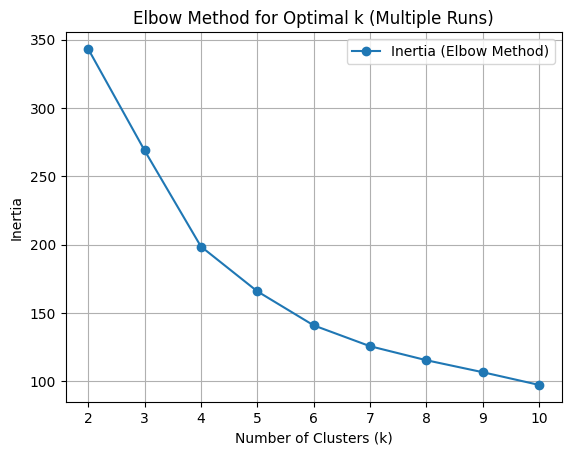

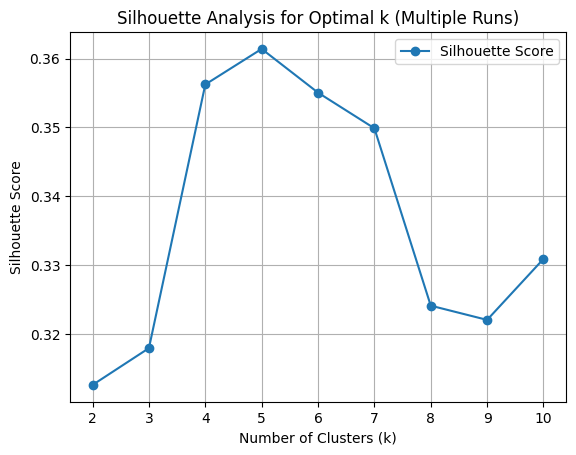

In [6]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def optimal_clusters_with_multiple_runs(data, max_k=10, n_iter=10):
    inertia = []
    silhouette_scores = []
    best_inertia_for_k = []
    k_values = range(2, max_k + 1)

    for k in k_values:
        min_inertia = float('inf')  
        best_kmeans = None

        for _ in range(n_iter):  
            kmeans = KMeans(n_clusters=k, random_state=None)  # Random initialization each time
            kmeans.fit(data)

            if kmeans.inertia_ < min_inertia:
                min_inertia = kmeans.inertia_
                best_kmeans = kmeans

        inertia.append(min_inertia)
        best_inertia_for_k.append(min_inertia)

        silhouette_scores.append(silhouette_score(data, best_kmeans.labels_))

    plt.figure()
    plt.plot(k_values, inertia, marker='o', linestyle='-', label='Inertia (Elbow Method)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k (Multiple Runs)')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', label='Silhouette Score')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k (Multiple Runs)')
    plt.legend()
    plt.grid()
    plt.show()

    return inertia, silhouette_scores, best_inertia_for_k

inertia, silhouette_scores, best_inertia = optimal_clusters_with_multiple_runs(normalized_train_data, max_k=10, n_iter=10)


How I choose K: While the Elbow Method suggested \( k = 4 \), the highest silhouette score at \( k = 5 \) indicated better-defined clusters, so I chose \( k = 5 \).

In [7]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=10)
kmeans.fit(normalized_train_data)

test_cluster_labels = kmeans.predict(normalized_test_data)

normalized_test_data['Predicted Cluster'] = test_cluster_labels

normalized_test_data.to_csv('predicts.csv', index=False)
print("Predicted clusters saved to 'predicts.csv'")
print("Test Data with Predicted Clusters:")
normalized_test_data.head()

Predicted clusters saved to 'predicts.csv'
Test Data with Predicted Clusters:


,Gender,Age,Annual Income (k$),Spending Score (1-100),Predicted Cluster
59,1,0.982018,-0.577646,-0.200426,2
5,0,-1.278219,-1.679734,0.968521,3
20,1,-0.330377,-1.413713,-0.629039,3
198,1,-0.549110,2.880630,-1.291442,4
52,0,-0.622021,-0.691655,0.111293,3


In [8]:
from sklearn.decomposition import PCA

org_test = normalized_test_data.drop(columns="Predicted Cluster")
org_train = normalized_train_data.copy()

pca = PCA(n_components=2)

train_pca = pca.fit_transform(org_train)
test_pca = pca.transform(org_test)

train_pca_df = pd.DataFrame(train_pca, columns=['PCA1', 'PCA2'])
test_pca_df = pd.DataFrame(test_pca, columns=['PCA1', 'PCA2'])


print("PCA-Reduced Training Data Sample:")
print(train_pca_df.head())

print("\nPCA-Reduced Test Data Sample:")
print(test_pca_df.head())


PCA-Reduced Training Data Sample:
       PCA1      PCA2
0 -0.101223  1.589685
1  1.595445 -2.061161
2 -1.079920 -1.053502
3  0.019350  0.375345
4  0.489331 -0.755673

PCA-Reduced Test Data Sample:
       PCA1      PCA2
0 -0.953668 -0.322274
1  1.151159 -2.023914
2 -0.552285 -1.350200
3  0.154314  2.853985
4  0.344214 -0.820784


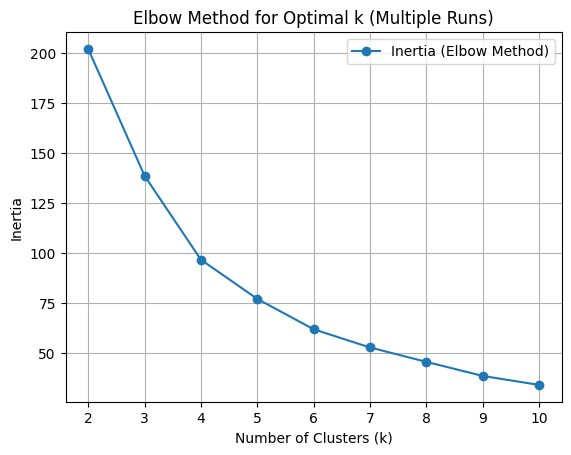

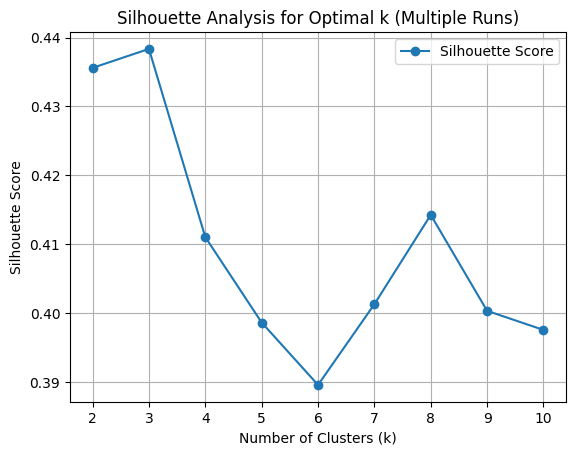

In [9]:
inertia, silhouette_scores, best_inertia = optimal_clusters_with_multiple_runs(train_pca_df, max_k=10, n_iter=10)


After redusing the dimentionality using PCA, the optimal value for the number of clusters appears to be 3 or 4 which I will try them both and then choose one.

In [23]:
k = 3

In [24]:
pca_kmeans = KMeans(n_clusters=k, random_state=10)
pca_kmeans.fit(train_pca_df)

test_pca_clusters = pca_kmeans.predict(test_pca_df)

normalized_test_data['PCA Cluster'] = test_pca_clusters

normalized_test_data.to_csv('predicts.csv', index=False)

print("Predicted PCA clusters saved to 'predicts.csv'")
print("Test Data with Predicted PCA Clusters:")
normalized_test_data.head()

Predicted PCA clusters saved to 'predicts.csv'
Test Data with Predicted PCA Clusters:


,Gender,Age,Annual Income (k$),Spending Score (1-100),Predicted Cluster,PCA Cluster
59,1,0.982018,-0.577646,-0.200426,2,0
5,0,-1.278219,-1.679734,0.968521,3,1
20,1,-0.330377,-1.413713,-0.629039,3,1
198,1,-0.549110,2.880630,-1.291442,4,2
52,0,-0.622021,-0.691655,0.111293,3,1


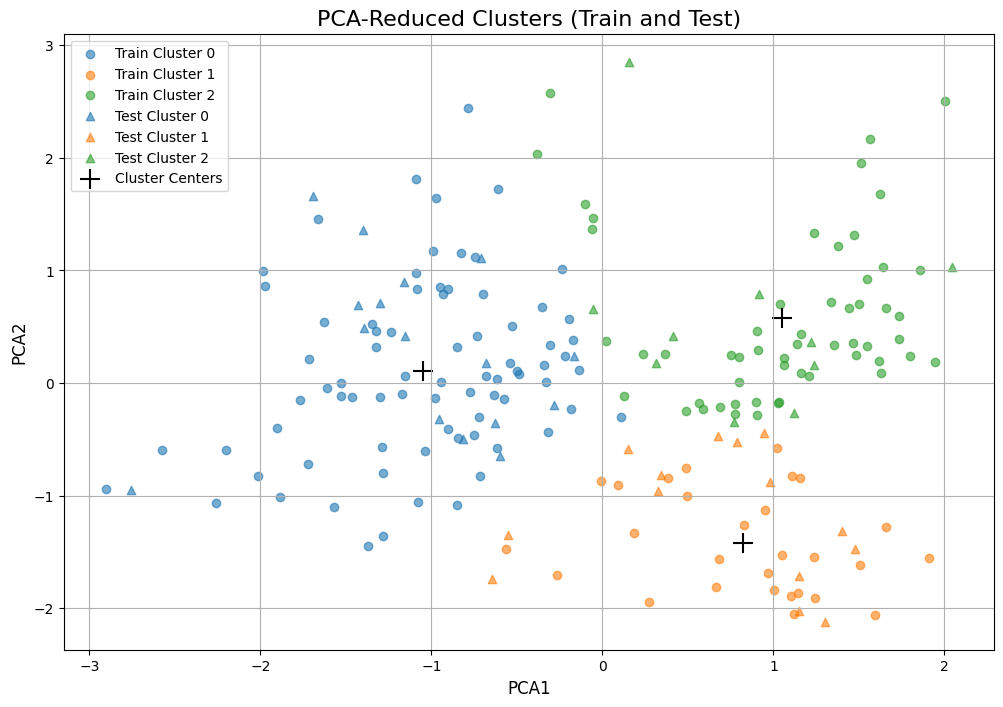

In [25]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.cm.tab10(np.arange(k))  

plt.figure(figsize=(12, 8))

for cluster in range(k): 
    cluster_data = train_pca[pca_kmeans.labels_ == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Train Cluster {cluster}',
                color=colors[cluster], alpha=0.6, marker='o')

for cluster in range(k):
    cluster_data = test_pca[test_pca_clusters == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Test Cluster {cluster}',
                color=colors[cluster], alpha=0.6, marker='^')

pca_cluster_centers = pca_kmeans.cluster_centers_

# Add cluster centers
plt.scatter(pca_cluster_centers[:, 0], pca_cluster_centers[:, 1], color='black',
            label='Cluster Centers', marker='+', s=200)

# Add plot details
plt.title('PCA-Reduced Clusters (Train and Test)', fontsize=16)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend()
plt.grid()
plt.show()
